In [1]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
from torchinfo import summary
import torch.nn as nn
import argparse, os, json, sys
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import h5py
from EvalTools import *
sys.path.append("../model")
from PFINDataset import PFINDataset
from UQPFIN import UQPFIN as Model
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#optional parameters to only evaluate certain models
optional_dataset = ''
optional_tag = ''
results_dir = 'results/'
saved_model_loc = "../model/trained_models/"
saved_model_dict_loc = "../model/trained_model_dicts/"

result_files = sorted([f for f in os.listdir(results_dir) if optional_dataset in f and optional_tag in f
                      and "MCDO" in f and '.h5' in f])
print('\n'.join(result_files))

RESULTS_UQPFIN_MCDO_JNqgmerged_baseline.h5
RESULTS_UQPFIN_MCDO_JNqgmerged_skiptop.h5
RESULTS_UQPFIN_MCDO_JNqgmerged_skipwz.h5
RESULTS_UQPFIN_MCDO_jetnet_baseline.h5
RESULTS_UQPFIN_MCDO_jetnet_skiptop.h5
RESULTS_UQPFIN_MCDO_jetnet_skiptwz.h5
RESULTS_UQPFIN_MCDO_jetnet_skipwz.h5
RESULTS_UQPFIN_MCDO_topdata_baseline.h5


In [5]:
model_results = {}

for modelname in result_files:
    mname = modelname[15:-3]
    filename = os.path.join(results_dir, modelname)
    
    f = h5py.File(filename, "r")
    model_results[mname] = {'labels' : f['labels'][:], 
                               'preds': f['preds'][:], 
                               'maxprobs': f['maxprobs'][:],
                               'sums':f['sums'][:], 
                               'oods':f['oods'][:],
                               'uncs': f['uncs'][:],
                               'probs': f['probs'][:]}
    labels, preds, oods, probs = f['labels'][:], f['preds'][:], f['oods'][:], f['probs'][:]
    f.close()
    acc = accuracy_score(labels[~oods], preds[~oods])*100
    if "topdata" in mname:
        probs2=probs
    else:
        skiplabels = np.unique(labels[oods])
        probs2=np.delete(probs, skiplabels, 1)

    if probs2.shape[1] == 2:
        probs2 = probs2[:, 1]

    auc = roc_auc_score(labels[~oods], probs2[~oods], multi_class='ovo')*100
        
    print("{} \t\t Accuracy: {:.2f}% \t AUC: {:.2f}%".format(mname, acc, auc))    

MCDO_JNqgmerged_baseline 		 Accuracy: 84.50% 	 AUC: 96.45%
MCDO_JNqgmerged_skiptop 		 Accuracy: 86.84% 	 AUC: 96.03%
MCDO_JNqgmerged_skipwz 		 Accuracy: 90.56% 	 AUC: 96.76%
MCDO_jetnet_baseline 		 Accuracy: 79.67% 	 AUC: 95.37%
MCDO_jetnet_skiptop 		 Accuracy: 81.03% 	 AUC: 94.89%
MCDO_jetnet_skiptwz 		 Accuracy: 83.30% 	 AUC: 91.03%
MCDO_jetnet_skipwz 		 Accuracy: 81.73% 	 AUC: 94.02%
MCDO_topdata_baseline 		 Accuracy: 93.34% 	 AUC: 98.20%


MCDO_JNqgmerged_baseline


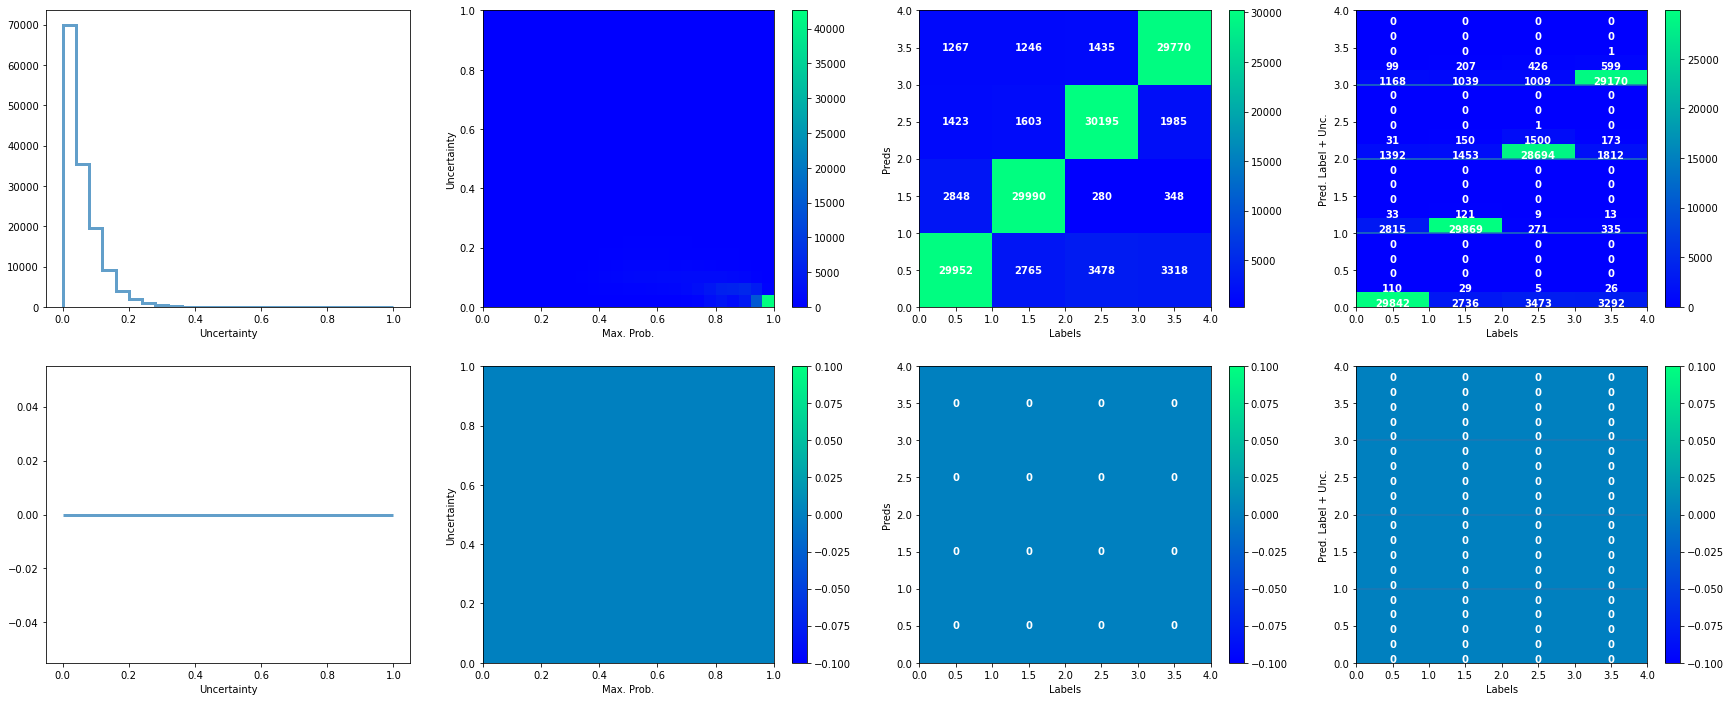

MCDO_JNqgmerged_skiptop


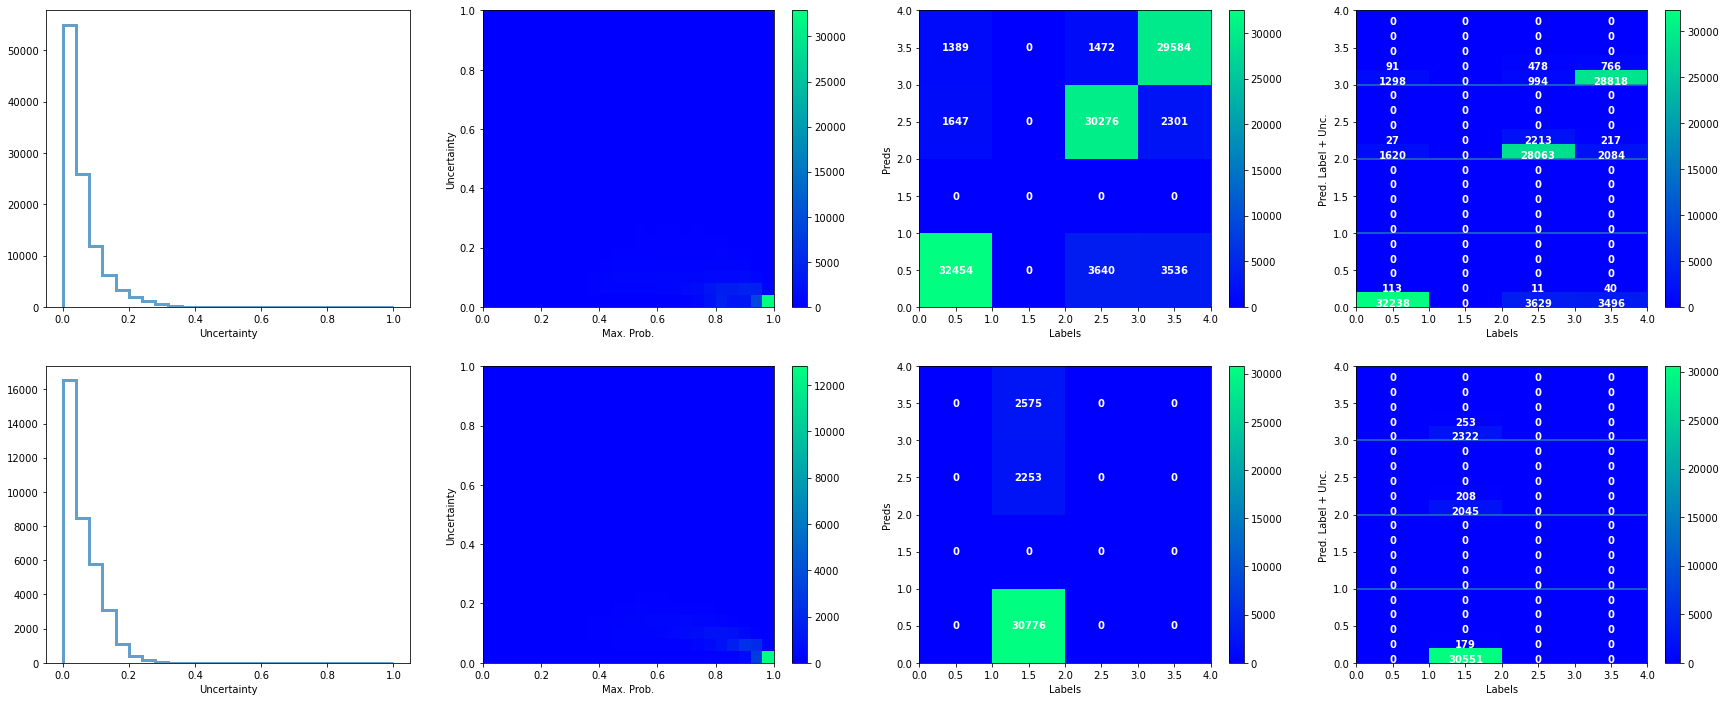

MCDO_JNqgmerged_skipwz


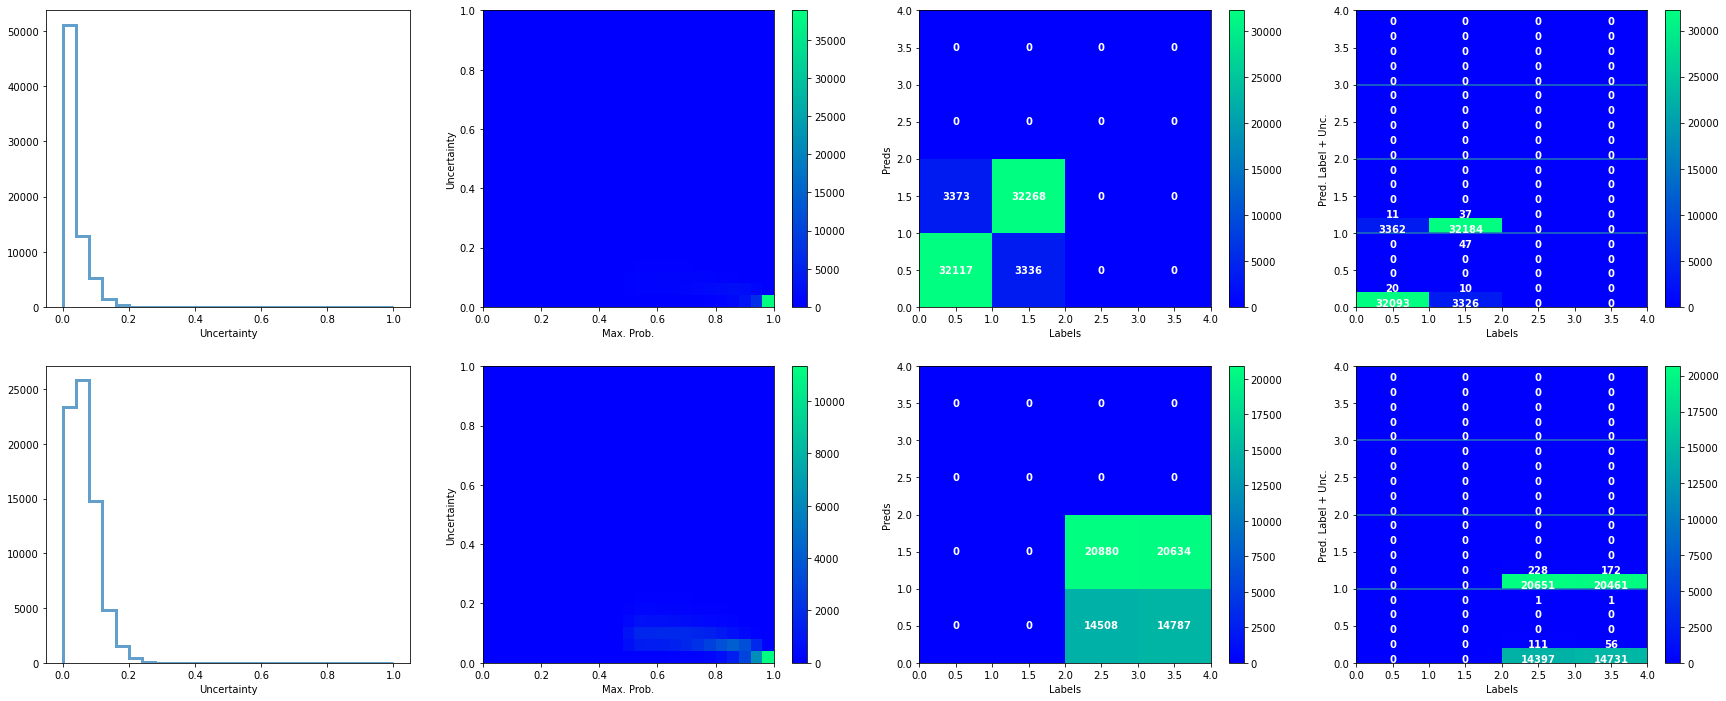

MCDO_jetnet_baseline


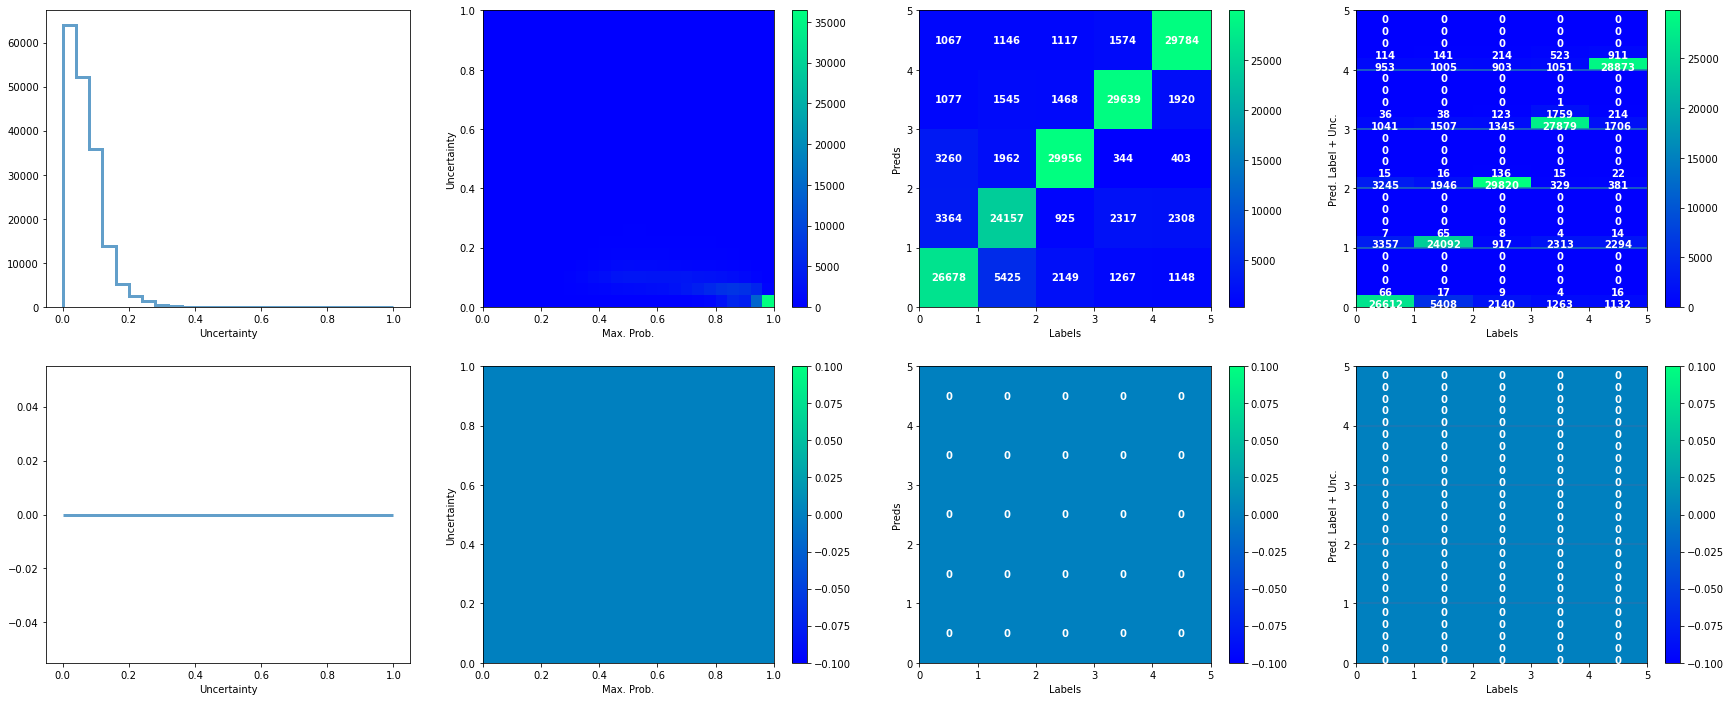

MCDO_jetnet_skiptop


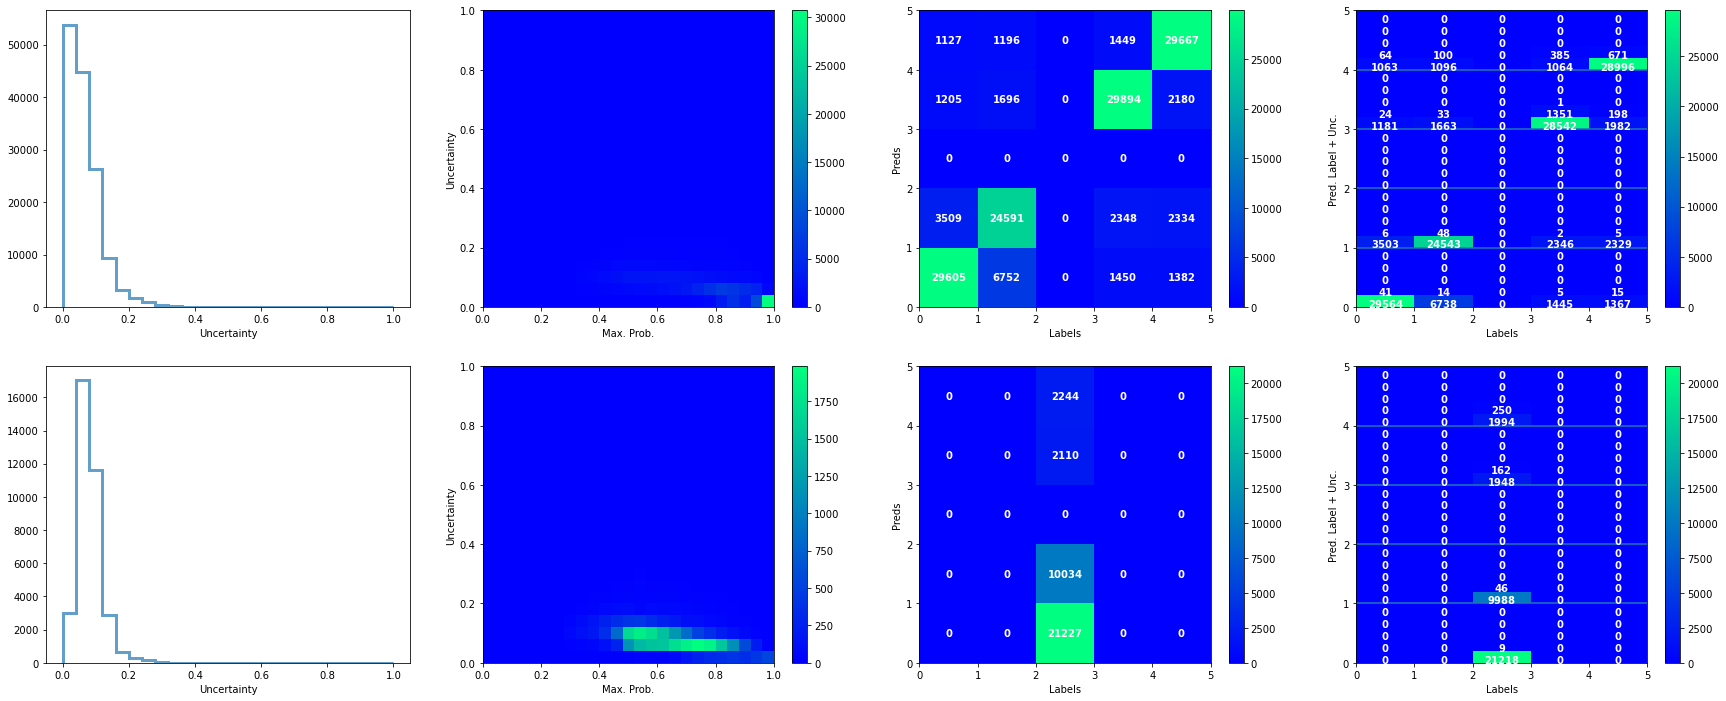

MCDO_jetnet_skiptwz


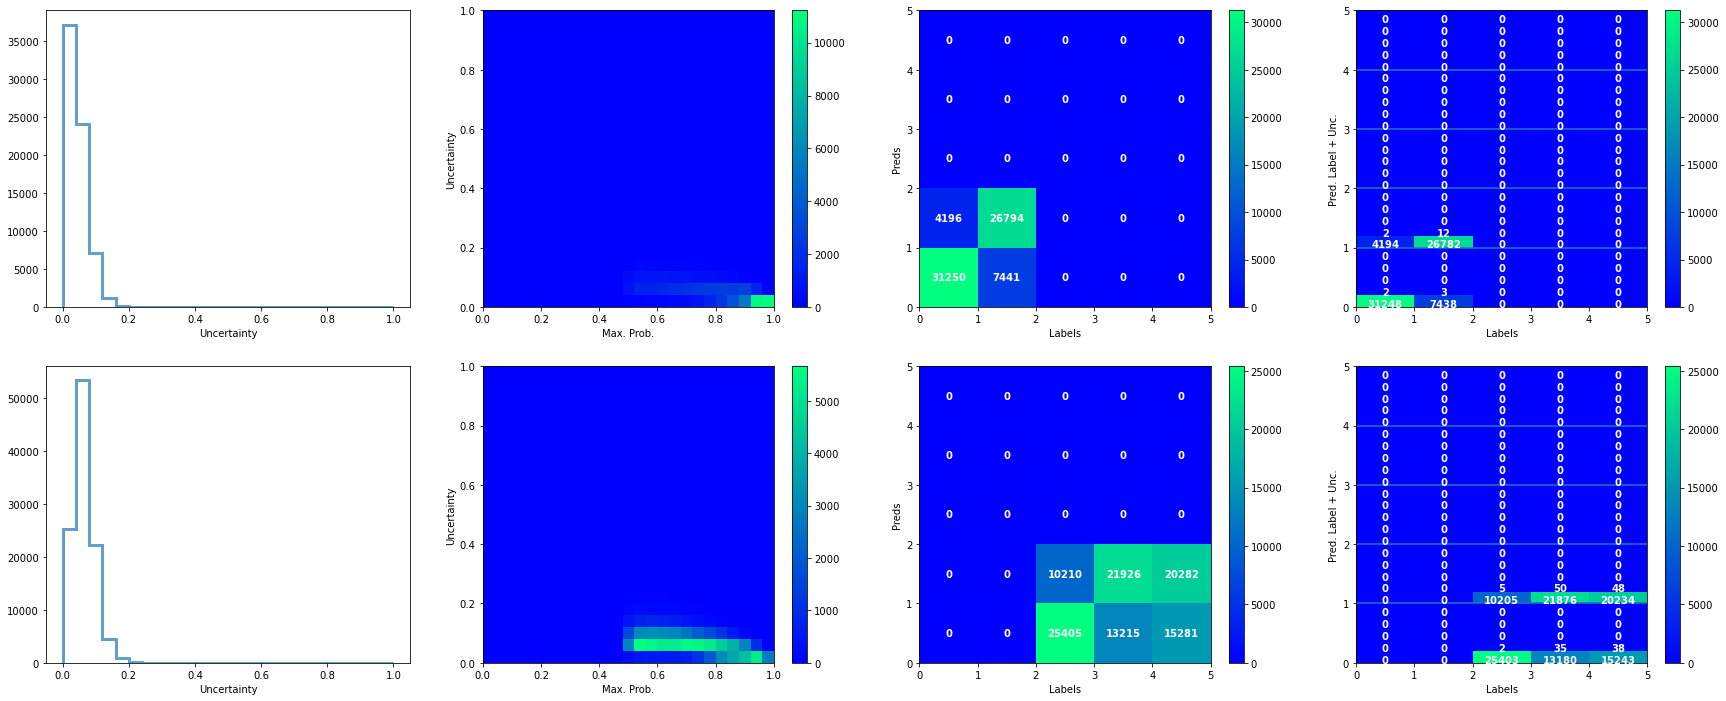

MCDO_jetnet_skipwz


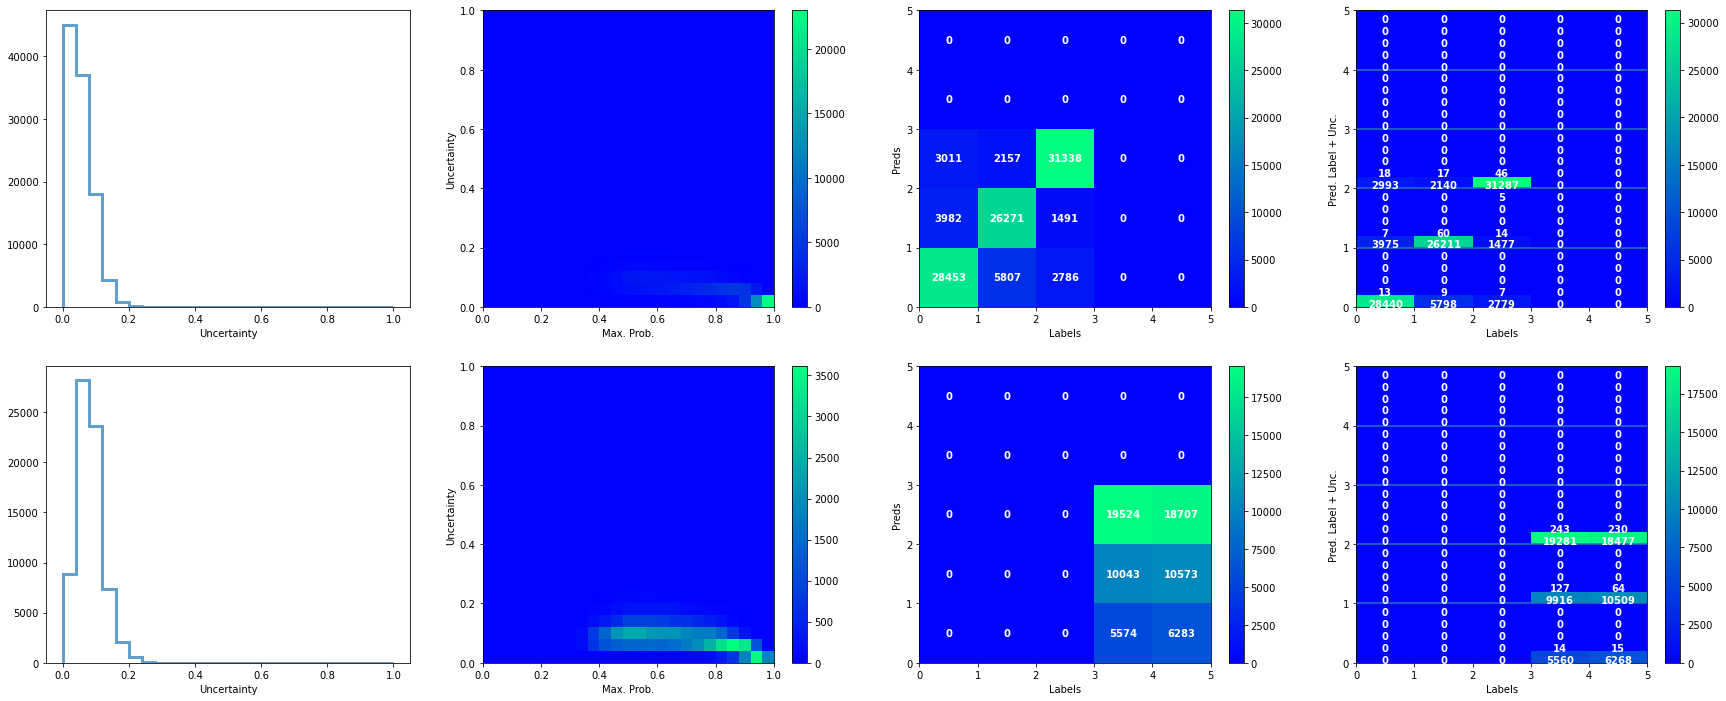

MCDO_topdata_baseline


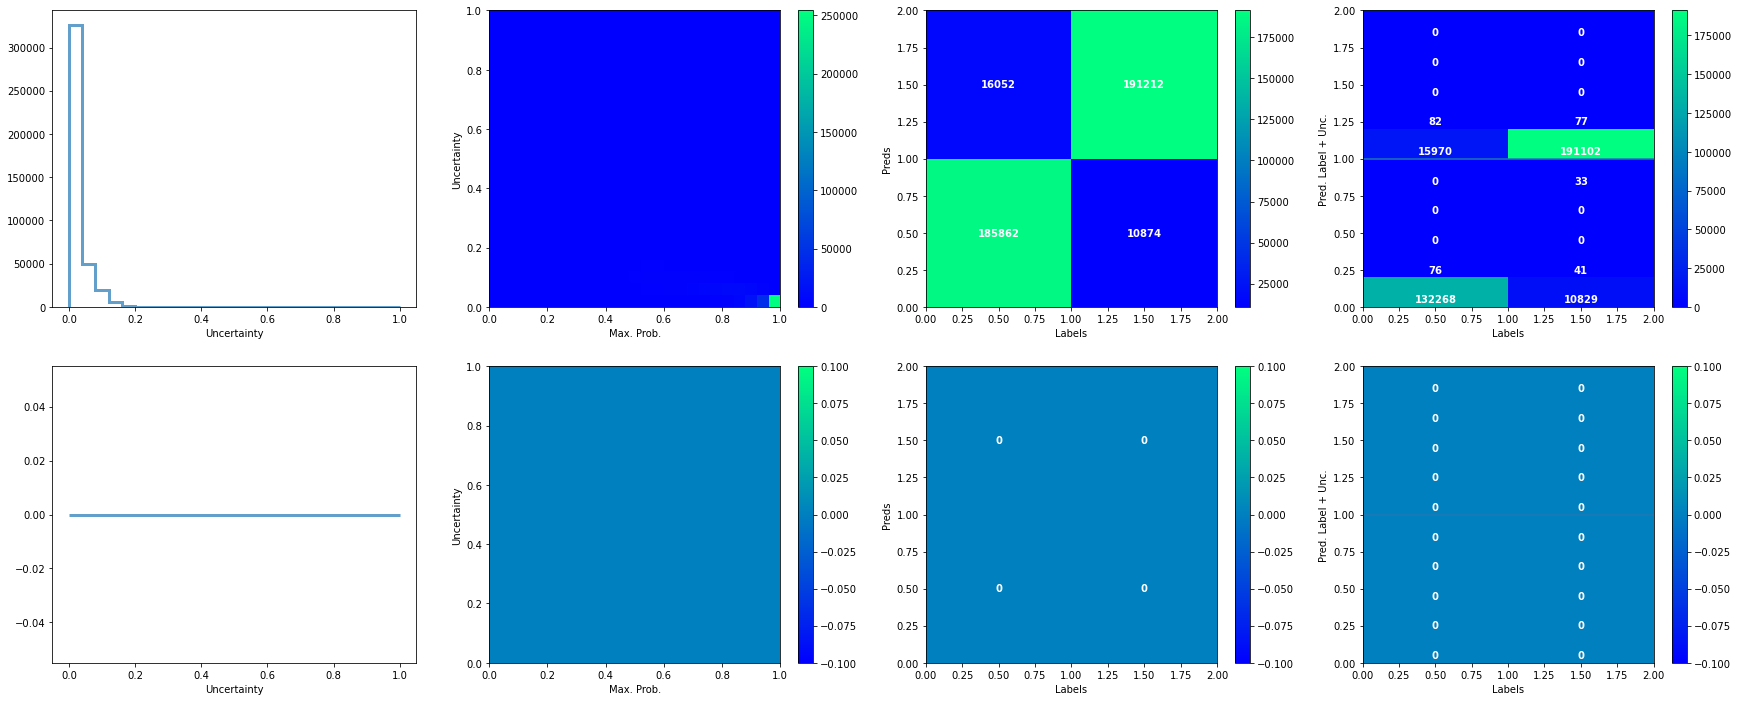

In [6]:
for key in model_results.keys():
    print(key)
    if "jetnet" in key:
        l_max = 5.1
    elif "jetclass" in key:
        l_max = 10.1
    elif "JNqgmerged" in key:
        l_max = 4.1
    else:
        l_max = 2.1
    
    labels, preds, maxprobs, sums, oods, uncs = model_results[key]['labels'], model_results[key]['preds'], \
                                                model_results[key]['maxprobs'], model_results[key]['sums'], \
                                                model_results[key]['oods'], model_results[key]['uncs'],
    
    fig, axes = plt.subplots(2, 4, figsize=(6*5, 6*2), sharex = False, sharey = False)
    
    axes[0, 0].hist(uncs[~oods],
                    bins=np.arange(0.,1.01,0.04), 
                    label=key + '(~oods)', 
                    alpha = 0.7, 
                    histtype = 'step', linewidth = 3)
    axes[0, 0].set_xlabel("Uncertainty")
    axes[1, 0].hist(uncs[oods],
                    bins=np.arange(0.,1.01,0.04), 
                    label=key + '(oods)', 
                    alpha = 0.7, 
                    histtype = 'step', linewidth = 3)
    axes[1, 0].set_xlabel("Uncertainty")
    
    
    h = axes[0, 1].hist2d(maxprobs[~oods], uncs[~oods], 
                          cmap = 'winter',
                          bins = [np.arange(0.,1.01,0.04), np.arange(0.,1.01,0.04)])
    fig.colorbar(h[3], ax=axes[0, 1])
    axes[0, 1].set_xlabel("Max. Prob.")
    axes[0, 1].set_ylabel("Uncertainty")
    
    h = axes[1, 1].hist2d(maxprobs[oods], uncs[oods], 
                          cmap = 'winter',
                          bins = [np.arange(0.,1.01,0.04), np.arange(0.,1.01,0.04)])
    fig.colorbar(h[3], ax=axes[1, 1])
    axes[1, 1].set_xlabel("Max. Prob.")
    axes[1, 1].set_ylabel("Uncertainty")
    
    
    h = axes[0, 2].hist2d(labels[~oods], preds[~oods], 
                          cmap = 'winter',
                          bins = [np.arange(0.,l_max,1), np.arange(0.,l_max,1)])
    
    for i in range(len(h[2])-1):
        for j in range(len(h[1])-1):
            axes[0,2].text(h[1][j]+0.5,h[2][i]+0.5, int(h[0].T[i,j]), 
                           color="w", ha="center", va="center", fontweight="bold")

    fig.colorbar(h[3], ax=axes[0, 2])
    axes[0, 2].set_xlabel("Labels")
    axes[0, 2].set_ylabel("Preds")
    
    h = axes[1, 2].hist2d(labels[oods], preds[oods], 
                          cmap = 'winter',
                          bins = [np.arange(0.,l_max,1), np.arange(0.,l_max,1)])
    for i in range(len(h[2])-1):
        for j in range(len(h[1])-1):
            axes[1,2].text(h[1][j]+0.5,h[2][i]+0.5, int(h[0].T[i,j]), 
                           color="w", ha="center", va="center", fontweight="bold")
    fig.colorbar(h[3], ax=axes[1, 2])
    axes[1, 2].set_xlabel("Labels")
    axes[1, 2].set_ylabel("Preds")
    
    
    h = axes[0, 3].hist2d(labels[~oods], uncs[~oods] + preds[~oods] -1.e-4, 
                          cmap = 'winter',
                          bins = [np.arange(0.,l_max,1), np.arange(0.,l_max,0.2)])
    fig.colorbar(h[3], ax=axes[0, 3])
    axes[0, 3].set_xlabel("Labels")
    axes[0, 3].set_ylabel("Pred. Label + Unc.")
    for i in range(len(h[2])-1):
        for j in range(len(h[1])-1):
            axes[0,3].text(h[1][j]+0.5,h[2][i]+0.05, int(h[0].T[i,j]), 
                           color="w", ha="center", va="center", fontweight="bold")
    for jj in np.arange(1,l_max,1):
        axes[0, 3].axhline(jj)
    
    h = axes[1, 3].hist2d(labels[oods], uncs[oods] + preds[oods] -1.e-4, 
                          cmap = 'winter',
                          bins = [np.arange(0.,l_max,1), np.arange(0.,l_max,0.2)])
    fig.colorbar(h[3], ax=axes[1, 3])
    axes[1, 3].set_xlabel("Labels")
    axes[1, 3].set_ylabel("Pred. Label + Unc.")
    for i in range(len(h[2])-1):
        for j in range(len(h[1])-1):
            axes[1,3].text(h[1][j]+0.5,h[2][i]+0.05, int(h[0].T[i,j]), 
                           color="w", ha="center", va="center", fontweight="bold")
            
    for jj in np.arange(1,l_max,1):
        axes[1, 3].axhline(jj)
            
    plt.show()
